In [28]:
import torch
torch.cuda.is_available()
print(torch.zeros(1).cuda())

import torch_geometric
import torch_geometric.nn as pyg_nn
from torch_sparse import SparseTensor, matmul
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
print(torch_geometric.__version__)

import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

import networkx as nx
from deepsnap.hetero_graph import HeteroGraph
import copy
from copy import deepcopy
import pickle

import deepsnap
from deepsnap.graph import Graph
from deepsnap.batch import Batch
from deepsnap.dataset import GraphDataset
from deepsnap.hetero_gnn import forward_op
from deepsnap.hetero_graph import HeteroGraph
from sklearn.metrics import f1_score, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import json
from pathlib import Path as Data_Path
from os import listdir
from os.path import isfile, join
from itertools import combinations
from tqdm.notebook import tqdm

import graph_tool.all as gt
import json
print("graph-tool version: {}".format(gt.__version__.split(' ')[0]))

tensor([0.], device='cuda:0')
2.1.0
graph-tool version: 2.46


In [29]:
import pickle

with open("../graph_pt_100.pickle", "rb") as f:
    final_graph = pickle.load(f)

In [30]:
print("Number of vertices:", final_graph.num_vertices())
print("Number of edges:", final_graph.num_edges())

Number of vertices: 3644438
Number of edges: 6746550


In [31]:
print('without artists as nodes:')
print("Number of vertices:", final_graph.num_vertices())
print("Number of edges:", final_graph.num_edges())

without artists as nodes:
Number of vertices: 3644438
Number of edges: 6746550


In [32]:
# count_pl = sum(1 for v in final_graph.vertices() if final_graph.vp.pl_type[v] == "playlist")
# print(f'num_playlists: {count_pl}')
# count_tr = sum(1 for v in final_graph.vertices() if final_graph.vp.tr_type[v] == "track")
# print(f'num_tracks: {count_tr}')
# count_ar = sum(1 for v in final_graph.vertices() if final_graph.vp.ar_type[v] == "artist")
# print(f'num_artist: {count_ar}')

In [33]:
print('without artists as nodes:')
count_pl = sum(1 for v in final_graph.vertices() if final_graph.vp.pl_type[v] == "playlist")
print(f'num_playlists: {count_pl}')
count_tr = sum(1 for v in final_graph.vertices() if final_graph.vp.tr_type[v] == "track")
print(f'num_tracks: {count_tr}')
count_ar = sum(1 for v in final_graph.vertices() if final_graph.vp.ar_type[v] == "artist")
print(f'num_artist: {count_ar}')

without artists as nodes:
num_playlists: 102000
num_tracks: 3542438
num_artist: 0


In [34]:
### Removal of duplicate nodes from pickle file


# prop_name = "pl_type"

# # Create a dictionary of property values to vertex IDs
# vertex_dict = {}
# for v in final_graph.vertices():
#     value = final_graph.vp[prop_name][v]
#     if value not in vertex_dict:
#         vertex_dict[value] = [int(v)]
#     else:
#         vertex_dict[value].append(int(v))

# # Remove duplicate nodes
# for value, ids in vertex_dict.items():
#     if len(ids) > 1:
#         print(value,ids)
#         # # Merge the duplicate nodes into the first node
#         # first_id = ids[0]
#         # for other_id in ids[1:]:
#         #     final_graph.vertex(first_id).out_edges()[:] = gt.find_edge(final_graph, final_graph.vertex(first_id), final_graph.vertex(other_id))
#         #     final_graph.vertex(first_id).out_edges()[:] = gt.find_edge(final_graph, final_graph.vertex(other_id), final_graph.vertex(first_id))
#         #     final_graph.remove_vertex(final_graph.vertex(other_id))


# print("Number of vertices:", final_graph.num_vertices())
# print("Number of edges:", final_graph.num_edges())

### Largest component

#### Graph-tool

In [35]:
largest_comp = gt.extract_largest_component(final_graph)
# largest_comp = gt.GraphView(final_graph, vfilt = gt.label_largest_component(final_graph))

In [36]:
print('no artists:')
print("Number of vertices:", largest_comp.num_vertices()) 
print("Number of edges:", largest_comp.num_edges())

no artists:
Number of vertices: 38565
Number of edges: 6746550


In [37]:
print('no artists stats:')
print('----------------')
count_pl = sum(1 for v in largest_comp.vertices() if largest_comp.vp.pl_type[v] == "playlist")
print(f'num_playlists: {count_pl}')
count_tr = sum(1 for v in largest_comp.vertices() if largest_comp.vp.tr_type[v] == "track")
print(f'num_tracks: {count_tr}')
count_ar = sum(1 for v in largest_comp.vertices() if largest_comp.vp.ar_type[v] == "artist")
print(f'num_artist: {count_ar}')

no artists stats:
----------------
num_playlists: 2999
num_tracks: 35566
num_artist: 0


In [38]:
# #### Networkx
# nx_graph = nx.Graph()
# for node in final_graph.vertices():
#     nx_graph.add_node(int(node))
# for edge in final_graph.edges():
#     nx_graph.add_edge(int(edge.source()), int(edge.target()))

# from networkx.algorithms.components import is_connected
# is_connected(nx_graph)

# largest_cc = max(nx.connected_components(nx_graph), key=len)
# nx_largest_comp = nx.Graph(nx_graph.subgraph(largest_cc))
# print('Num nodes:', nx_largest_comp.number_of_nodes(), '. Num edges:', nx_largest_comp.number_of_edges())

### N-hop neighbourhood

In [39]:
pass

### Deepsnap

In [40]:
g_nx = nx.Graph()

# Add edges to NetworkX graph in batches
nx_g = nx.Graph()
for v in largest_comp.vertices():
    if(largest_comp.vp.pl_type[v]=='playlist'):
        typ='playlist'
    elif(largest_comp.vp.tr_type[v] == "track"):
        typ='track'
    node_attributes = {'name':largest_comp.vp.pl_name[v], 'uri':largest_comp.vp.tr_uri[v], 'type':typ}
    g_nx.add_node(int(v), **node_attributes)
for e in largest_comp.edges():
    g_nx.add_edge(int(e.source()), int(e.target()))
    
mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(g_nx.nodes()))}

# reindex the nodes in the graph
g_nx = nx.relabel_nodes(g_nx, mapping)
        
# Create a DeepSNAP graph from NetworkX graph
ds_graph = Graph(g_nx)

In [41]:
with open('g_nx.pickle', 'wb') as f:
    pickle.dump(g_nx, f)

In [42]:
print(g_nx.nodes[1000])

{'name': 'Awesome Playlist', 'uri': '', 'type': 'playlist'}


In [43]:
print(g_nx.edges(560))
print(largest_comp.vp.pl_name[10])

[(560, 23578), (560, 23579), (560, 23580), (560, 23581), (560, 23582), (560, 23583), (560, 23584), (560, 23585), (560, 23586), (560, 23587), (560, 23588), (560, 23589), (560, 23590), (560, 23591), (560, 23592), (560, 23593), (560, 23594), (560, 23595), (560, 23596), (560, 23597), (560, 23598), (560, 23599), (560, 24626), (560, 24627), (560, 24628), (560, 24629), (560, 24630), (560, 24631), (560, 24632), (560, 24633), (560, 24634), (560, 24635), (560, 24636), (560, 24637), (560, 24638), (560, 24639), (560, 24640), (560, 24641), (560, 24642), (560, 24643), (560, 24644), (560, 24645), (560, 24646), (560, 24647), (560, 24648), (560, 24649), (560, 24650), (560, 24651), (560, 24652), (560, 24653), (560, 24654), (560, 24655), (560, 24656), (560, 24657), (560, 24658), (560, 24659), (560, 24660), (560, 24661), (560, 24662), (560, 24663), (560, 24664), (560, 24665), (560, 24666), (560, 24667), (560, 24668), (560, 24669), (560, 24670), (560, 24671), (560, 24672), (560, 24673), (560, 24674), (560,

In [44]:
print("Number of vertices:", largest_comp.num_vertices()) 
print("Number of edges:", largest_comp.num_edges())

Number of vertices: 38565
Number of edges: 6746550


In [86]:
task = 'link_pred'
dataset = GraphDataset([ds_graph], task=task, edge_train_mode='disjoint')

dataset_train, dataset_val, dataset_test = dataset.split(transductive=True, split_ratio=[0.8, 0.1, 0.1])

# dataset_train[0].to('cuda')
# dataset_val[0].to('cuda')
# dataset_test[0].to('cuda')

# dataset_train.to('cuda:0')
# dataset_val.to('cuda:0')
# dataset_test.to('cuda:0')

print(type(dataset_train))
print(dataset_train[0])
print(type(dataset_train[0]))

num_train_edges = dataset_train[0].edge_label_index.shape[1]
num_val_edges = dataset_val[0].edge_label_index.shape[1]
num_test_edges = dataset_test[0].edge_label_index.shape[1]

print("Train set has {} supervision (positive) edges".format(num_train_edges // 2))
print("Validation set has {} supervision (positive) edges".format(num_val_edges // 2))
print("Test set has {} supervision (positive) edges".format(num_test_edges // 2))

print("Train set has {} message passing edges".format(dataset_train[0].edge_index.shape[1]))
print("Validation set has {} message passing edges".format(dataset_val[0].edge_index.shape[1]))
print("Test set has {} message passing edges".format(dataset_test[0].edge_index.shape[1]))

print(dataset)

<class 'deepsnap.dataset.GraphDataset'>
Graph(G=[], edge_index=[2, 2320892], edge_label=[1160448], edge_label_index=[2, 1160448], name=[38565], negative_label_val=[1], node_label_index=[38565], type=[38565], uri=[38565])
<class 'deepsnap.graph.Graph'>
Train set has 580224 supervision (positive) edges
Validation set has 362638 supervision (positive) edges
Test set has 362642 supervision (positive) edges
Train set has 2320892 message passing edges
Validation set has 2901116 message passing edges
Test set has 3263754 message passing edges
GraphDataset(1)


In [100]:
test_ds = dataset_test[0]
print(test_ds)
print(test_ds.edge_label)

Graph(G=[], edge_index=[2, 3263754], edge_label=[725284], edge_label_index=[2, 725284], name=[38565], negative_label_val=[1], node_label_index=[38565], type=[38565], uri=[38565])
tensor([1, 1, 1,  ..., 0, 0, 0])


In [95]:
train_ds = dataset_train[0]
train_ds

Graph(G=[], edge_index=[2, 2320892], edge_label=[1160448], edge_label_index=[2, 1160448], name=[38565], negative_label_val=[1], node_label_index=[38565], type=[38565], uri=[38565])

In [94]:
a.edge_label_index

tensor([[  578,   429,   991,  ..., 38065,  8079, 18137],
        [25011, 19146, 37349,  ...,  8851,  1926, 27728]])

In [90]:
dataset_test[0].negative_label_val

0

In [46]:
# pickle.dump(dataset_train, open('./graphs/train.graph', 'wb'))
# pickle.dump(dataset_val, open('./graphs/val.graph', 'wb'))
# pickle.dump(dataset_test, open('./graphs/test.graph', 'wb'))

In [47]:
# dataset_train = pickle.load(open('./graphs/train.graph', 'rb'))
# dataset_val = pickle.load(open('./graphs/val.graph', 'rb'))
# dataset_test = pickle.load(open('./graphs/test.graph', 'rb'))

In [48]:
class LightGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):  
        super(LightGCNConv, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

    def forward(self, x, edge_index, size = None):
        out = self.propagate(edge_index, x=(x, x))
        return out

    def message(self, x_j):
        out = x_j
        return out

    def aggregate(self, inputs, index, dim_size = None):
        node_dim = self.node_dim
        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce='mean')
        return out

In [49]:
class LightGCN(torch.nn.Module):
    def __init__(self, train_data, num_layers, emb_size=16, initialize_with_words=False):
        super(LightGCN, self).__init__()
        self.convs = nn.ModuleList()
        assert (num_layers >= 1), 'Number of layers is not >=1'
        for l in range(num_layers):
            self.convs.append(LightGCNConv(input_dim, input_dim))

        # Initialize using custom embeddings if provided
        num_nodes = train_data.node_label_index.size()[0]
        self.embeddings = nn.Embedding(num_nodes, emb_size)
        if initialize_with_words:
            self.embeddings.weight.data.copy_(train_datanode_features)
        
        self.loss_fn = nn.BCELoss()
        self.num_layers = num_layers
        self.emb_size = emb_size
        self.num_modes = num_nodes

    def forward(self, data):
        edge_index, edge_label_index, node_label_index = data.edge_index, data.edge_label_index, data.node_label_index
        layer_embeddings = []
        
        x = self.embeddings(node_label_index)
        mean_layer = x

        # We take an average of ever layer's node embeddings
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            # print("x shape",x.shape)
            # print("mean_layer shape",mean_layer.shape)
            mean_layer += x

        mean_layer /= 4

        # Prediction head is simply dot product
        nodes_first = torch.index_select(x, 0, edge_label_index[0,:].long())
        nodes_second = torch.index_select(x, 0, edge_label_index[1,:].long())

        # Since we don't want a rank output, we create a sigmoid of the dot product
        out = torch.sum(nodes_first * nodes_second, dim=-1) # FOR RANKING
        pred = torch.sigmoid(out)

        return torch.flatten(pred)

    def loss(self, pred, label):
        return self.loss_fn(pred, label)

In [50]:
import warnings
warnings.filterwarnings('ignore')

In [51]:
print(type(dataset_train))

<class 'deepsnap.dataset.GraphDataset'>


In [52]:
args = {
    'device' : 'cuda' if torch.cuda.is_available() else 'cpu',
    'num_layers' : 3,
    'emb_size' : 32,
    'weight_decay': 1e-5,
    'lr': 0.01,
    'epochs': 600
}

datasets = {
    'train': dataset_train[0],
    'val': dataset_val[0],
    'test': dataset_test[0]
}
            
input_dim = datasets['train'].num_node_features
print(input_dim, args)

0 {'device': 'cuda', 'num_layers': 3, 'emb_size': 32, 'weight_decay': 1e-05, 'lr': 0.01, 'epochs': 600}


In [53]:
# datasets['train'].to(args['device'])
# datasets['val'].to(args['device'])
# datasets['test'].to(args['device'])

In [54]:
losses = []

def train(model, optimizer, args):
    val_max = 0
    best_model = model

    for epoch in range(1, args['epochs'] + 1):
        datasets['train'].to(args["device"])
        model.train()
        optimizer.zero_grad()
        pred = model(datasets['train'])
        loss = model.loss(pred, datasets['train'].edge_label.type(pred.dtype))

        loss.backward()
        optimizer.step()

        log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Loss: {:.5f}, Val Loss: {:.5f}'
        score_train, train_loss = test(model, 'train', args)
        score_val, val_loss = test(model, 'val', args)
        score_test, test_loss = test(model, 'test', args)

        losses.append((train_loss, val_loss))

        print(log.format(epoch, score_train, score_val, score_test, train_loss, val_loss))
        if val_max < score_val:
            val_max = score_val
            best_model = copy.deepcopy(model)

    return best_model

def test(model, mode, args):
    model.eval()
    score = 0
    loss_score = 0

    data = datasets[mode]
    data.to(args["device"])

    pred = model(data)
    loss = model.loss(pred, data.edge_label.type(pred.dtype))
    score += roc_auc_score(data.edge_label.flatten().cpu().numpy(), pred.flatten().data.cpu().numpy())
    loss_score += loss.item()

    return score, loss_score

In [56]:
model = LightGCN(datasets['train'], args['num_layers'], emb_size=args['emb_size']).to(args['device'])
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

best_model = train(model, optimizer, args)
log = "Train: {:.4f}, Val: {:.4f}, Test: {:.4f}, Train Loss: {:.5f}, Val Loss: {:.5f}, Test Loss: {:.5f}"
best_train_roc, train_loss = test(best_model, 'train', args)
best_val_roc, val_loss = test(best_model, 'val', args)
best_test_roc, test_loss = test(best_model, 'test', args)
print(log.format(best_train_roc, best_val_roc, best_test_roc, train_loss, val_loss, test_loss))

Epoch: 001, Train: 0.5332, Val: 0.5286, Test: 0.5298, Loss: 0.69774, Val Loss: 0.69795
Epoch: 002, Train: 0.5993, Val: 0.5952, Test: 0.5962, Loss: 0.69545, Val Loss: 0.69565
Epoch: 003, Train: 0.6430, Val: 0.6393, Test: 0.6399, Loss: 0.69389, Val Loss: 0.69406
Epoch: 004, Train: 0.6703, Val: 0.6665, Test: 0.6668, Loss: 0.69285, Val Loss: 0.69301
Epoch: 005, Train: 0.6874, Val: 0.6841, Test: 0.6841, Loss: 0.69217, Val Loss: 0.69233
Epoch: 006, Train: 0.6994, Val: 0.6965, Test: 0.6964, Loss: 0.69171, Val Loss: 0.69187
Epoch: 007, Train: 0.7086, Val: 0.7061, Test: 0.7060, Loss: 0.69138, Val Loss: 0.69153
Epoch: 008, Train: 0.7167, Val: 0.7145, Test: 0.7145, Loss: 0.69111, Val Loss: 0.69126
Epoch: 009, Train: 0.7244, Val: 0.7225, Test: 0.7226, Loss: 0.69085, Val Loss: 0.69100
Epoch: 010, Train: 0.7321, Val: 0.7304, Test: 0.7306, Loss: 0.69058, Val Loss: 0.69074
Epoch: 011, Train: 0.7397, Val: 0.7382, Test: 0.7385, Loss: 0.69030, Val Loss: 0.69045
Epoch: 012, Train: 0.7470, Val: 0.7457, Tes

In [57]:
#model_save
filename = 'best_lgcn.pkl'
torch.save(best_model, filename)

#datasets save
# with open('datasets_deepsnap_dict.pkl', 'wb') as f:
#     # pickle the dictionary and write it to the file
#     pickle.dump(datasets, f)

# model = torch.load('../lgcn.pkl')
# with open('../datasets_deepsnap_dict.pkl', 'rb') as f:
#     # load the pickled dictionary from the file
#     datasets = pickle.load(f)

In [58]:
def plot_learning_curve(losses, title):
    train_loss, val_loss = zip(*losses)
    steps = list(range(1, len(train_loss) + 1))
    
    min_val_loss = np.round(np.min(val_loss), 3)
    # train_list = [math.log10(x) for x in train_loss]
    # val_list = [math.log10(x) for x in val_loss]
    
    plt.figure(figsize=(16, 6))
    plt.plot(steps, train_loss, '-r', label='Training Loss')
    plt.plot(steps, val_loss, '-b', label='Validation Loss')
    plt.hlines(min_val_loss, 1, 300, colors='k', linestyles='dotted', label='Min Validation Loss: {}'.format(min_val_loss))

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # plt.ylim((0.58, 0.71))
    plt.title(title)
    plt.legend(loc='upper right')
    plt.title(title)

    return plt

<module 'matplotlib.pyplot' from '/home/asd27/.conda/envs/cudatorch/lib/python3.11/site-packages/matplotlib/pyplot.py'>

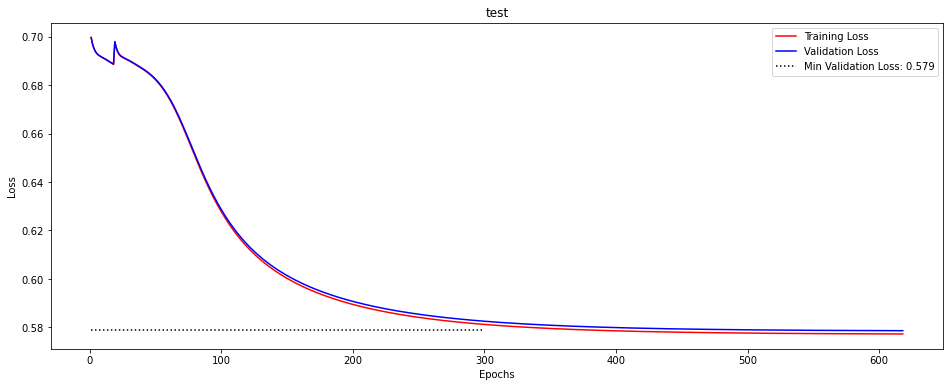

In [59]:
plot_learning_curve(losses, 'test')

In [60]:
data = datasets['test']
pred = model(data)

In [61]:
pred

tensor([0.6940, 0.6075, 0.6814,  ..., 0.5872, 0.6009, 0.4303], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

In [62]:
len(pred)

725284

In [63]:
ds = datasets['test']
ds

Graph(G=[], edge_index=[2, 3263754], edge_label=[725284], edge_label_index=[2, 725284], name=[38565], negative_label_val=[1], node_label_index=[38565], type=[38565], uri=[38565])

In [64]:
ds.edge_label

tensor([1, 1, 1,  ..., 0, 0, 0], device='cuda:0')

In [65]:
type(ds.edge_label_index)

torch.Tensor

In [66]:
dict1 = {'preds':pred.to('cpu').detach().numpy(), 'edge_label': ds.edge_label.to('cpu').detach().numpy(), 'src_node': ds.edge_label_index[0].to('cpu').detach().numpy(), 'dest_node': ds.edge_label_index[1].to('cpu').detach().numpy()}
df = pd.DataFrame(dict1)
df.head()

,preds,edge_label,src_node,dest_node
0,0.694010,1,663,26709
1,0.607457,1,959,36647
2,0.681380,1,562,24836
3,0.635903,1,225,12467
4,0.635222,1,230,12723


In [67]:
df_0 = df[df['edge_label'] == 0]
df_0

,preds,edge_label,src_node,dest_node
362642,0.639193,0,32716,38339
362643,0.497316,0,1707,34635
362644,0.458209,0,1060,25937
362645,0.377160,0,11428,29437
362646,0.327507,0,24659,33235
...,...,...,...,...
725279,0.613643,0,8207,11693
725280,0.340819,0,20530,31785
725281,0.587192,0,29022,33586
725282,0.600884,0,22040,18148


In [68]:
df_1 = df[df['edge_label'] == 1]
df_1

,preds,edge_label,src_node,dest_node
0,0.694010,1,663,26709
1,0.607457,1,959,36647
2,0.681380,1,562,24836
3,0.635903,1,225,12467
4,0.635222,1,230,12723
...,...,...,...,...
362637,0.690186,1,22543,525
362638,0.639454,1,9774,163
362639,0.671365,1,19429,412
362640,0.669155,1,18315,401


In [69]:
df_lessthan = df_1[df_1['preds'] > 0.5]
df_lessthan

,preds,edge_label,src_node,dest_node
0,0.694010,1,663,26709
1,0.607457,1,959,36647
2,0.681380,1,562,24836
3,0.635903,1,225,12467
4,0.635222,1,230,12723
...,...,...,...,...
362637,0.690186,1,22543,525
362638,0.639454,1,9774,163
362639,0.671365,1,19429,412
362640,0.669155,1,18315,401


In [70]:
df_lessthan.iloc[0]['src_node']

663.0

In [71]:
g_nx[0]

AtlasView({1000: {}, 1001: {}, 1002: {}, 1003: {}, 1004: {}, 1005: {}, 1006: {}, 1007: {}, 1008: {}, 1009: {}, 1010: {}, 1011: {}, 1012: {}, 1013: {}, 1014: {}, 1015: {}, 1016: {}, 1017: {}, 1018: {}, 1019: {}, 1020: {}, 1021: {}, 1022: {}, 1023: {}, 1024: {}, 1025: {}, 1026: {}, 1027: {}, 1028: {}, 1029: {}, 1030: {}, 1031: {}, 1032: {}, 1033: {}, 1034: {}, 1035: {}, 1036: {}, 1037: {}, 1038: {}, 1039: {}, 1040: {}, 1041: {}, 1042: {}, 1043: {}, 1044: {}, 1045: {}, 1046: {}, 1047: {}, 1048: {}, 1049: {}, 1050: {}, 1051: {}, 1052: {}, 1053: {}, 1054: {}, 1055: {}, 1056: {}, 1057: {}, 1058: {}, 1059: {}, 1060: {}, 1061: {}, 1062: {}, 1063: {}, 1064: {}, 1065: {}, 1066: {}, 1067: {}, 1068: {}, 1069: {}, 1070: {}, 1071: {}, 1072: {}, 1073: {}, 1074: {}, 1075: {}, 1076: {}, 1077: {}, 1078: {}, 1079: {}, 1080: {}, 1081: {}, 1082: {}, 1083: {}, 1084: {}, 1085: {}, 1086: {}, 1087: {}, 1088: {}, 1089: {}, 1090: {}, 1091: {}, 1092: {}, 1093: {}, 1094: {}, 1095: {}, 1096: {}, 1097: {}, 1098: {},

In [72]:
df_lessthan.iloc[0]["src_node"]
counter=0
neg=0
for x in g_nx.nodes:
    if(counter!=x):
        neg=neg+x-counter
        counter=x
    counter=counter+1
print(len(g_nx.nodes))
neg
        

38565


0

In [73]:
def row_op(row):

    if g_nx.nodes[row['src_node']]['name'] == g_nx.nodes[row['dest_node']]['name'] or g_nx.nodes[row['src_node']]['uri'] == g_nx.nodes[row['dest_node']]['uri']:
        return False
    return True

df_lessthan['is_valid'] = df_lessthan.apply(row_op,axis=1)
df_filter=df_lessthan[df_lessthan['is_valid']] 

In [74]:
def getId(row):
    return pd.Series([g_nx.nodes[row['src_node']]['name'],g_nx.nodes[row['src_node']]['uri'],g_nx.nodes[row['src_node']]['type'],g_nx.nodes[row['dest_node']]['name'],g_nx.nodes[row['dest_node']]['uri'],g_nx.nodes[row['dest_node']]['type']])
    
df_filter[["src_name","src_uri","src_type","dest_name","dest_uri","dest_type"]]=df_filter[df_lessthan['is_valid']].apply(getId,axis=1)

In [75]:
df_filter

,preds,edge_label,src_node,dest_node,is_valid,src_name,src_uri,src_type,dest_name,dest_uri,dest_type
0,0.694010,1,663,26709,True,2000s hits,,playlist,,spotify:track:15KUDgDxvkghmtB6FxI7Dt,track
2,0.681380,1,562,24836,True,Country summer,,playlist,,spotify:track:3Cx9j78Z0NE6jYwBWvvV3P,track
3,0.635903,1,225,12467,True,Volleyball,,playlist,,spotify:track:5VJjhHyG8NZ5xdgG6uTb3P,track
4,0.635222,1,230,12723,True,Summer of love,,playlist,,spotify:track:1mXejq3WXXF7YaXnRoP1gq,track
5,0.643328,1,338,15711,True,((chris)),,playlist,,spotify:track:3gx6E5B42WHKf5agVWQAf2,track
...,...,...,...,...,...,...,...,...,...,...,...
362637,0.690186,1,22543,525,True,,spotify:track:3z9e5b0P7zoIeV6I3iyX8O,track,Tejano,,playlist
362638,0.639454,1,9774,163,True,,spotify:track:0scQIzgcOhnmfqfOTpRUFH,track,pump,,playlist
362639,0.671365,1,19429,412,True,,spotify:track:48td6xvpokdYwvbl3JIiXP,track,Country,,playlist
362640,0.669155,1,18315,401,True,,spotify:track:1ntaQ5nSrrbJwEuwAAbHiY,track,GET DOWN,,playlist


In [76]:
df_final = df_filter[(df_filter['src_name']=="Party mix") | ( df_filter['dest_name']=="Party mix") ]
df_final.sort_values('preds',ascending=False)
uri_list=list(df_final.apply(lambda x: x['src_uri'] if x['src_uri']!='' else x['dest_uri'], axis=1 ))

In [77]:
# !pip install spotipy

In [78]:
uri_list=[]
uri_list = list(df_final["dest_uri"])

In [79]:
df_final

,preds,edge_label,src_node,dest_node,is_valid,src_name,src_uri,src_type,dest_name,dest_uri,dest_type
377,0.684027,1,575,24909,True,Party mix,,playlist,,spotify:track:7kT30Qf4aSg9lrwxsnGS2I,track
467,0.687354,1,575,23810,True,Party mix,,playlist,,spotify:track:5AnszA1GMtDt8CFIWMnwyg,track
712,0.687035,1,575,23886,True,Party mix,,playlist,,spotify:track:2AgnbuzvnfPvq1sAYNB4pj,track
1011,0.684099,1,575,23476,True,Party mix,,playlist,,spotify:track:1EAb9MI3olU3eiyGhrMylw,track
1148,0.659459,1,575,26096,True,Party mix,,playlist,,spotify:track:56DJzEuZugYdTYxi6VAdVh,track
...,...,...,...,...,...,...,...,...,...,...,...
358416,0.688048,1,24256,575,True,,spotify:track:7ek8SSCHpRuZQclgonvjJh,track,Party mix,,playlist
359953,0.676060,1,25420,575,True,,spotify:track:3RZrtVbjRfs9QTJx5nexVi,track,Party mix,,playlist
361173,0.687955,1,24390,575,True,,spotify:track:4vByq0ENplmS7kXAVOVNvq,track,Party mix,,playlist
361419,0.676737,1,22833,575,True,,spotify:track:4Pa5XXpn3sdBPMVCSWGEhB,track,Party mix,,playlist


In [80]:
uri_list

['spotify:track:7kT30Qf4aSg9lrwxsnGS2I',
 'spotify:track:5AnszA1GMtDt8CFIWMnwyg',
 'spotify:track:2AgnbuzvnfPvq1sAYNB4pj',
 'spotify:track:1EAb9MI3olU3eiyGhrMylw',
 'spotify:track:56DJzEuZugYdTYxi6VAdVh',
 'spotify:track:6K1UgfyTeJOW1pQkIw9cHL',
 'spotify:track:4J0S4iVmMT2RD4LaSCvLrT',
 'spotify:track:3GXJpmAGmA7SHUcB7xiejo',
 'spotify:track:4TkVE9FZudrKDdchZNTMqL',
 'spotify:track:5M3Y5AtDjsiXsEYtah1c0R',
 'spotify:track:1yxoUrEVFXcvKe8jrlXGVd',
 'spotify:track:4fIRVjtM6yoWPUrpQ1WH3H',
 'spotify:track:13Jvkdmbus4Cf6D91CSO6p',
 'spotify:track:1D7RHL8KWWOyPl5X7cElsw',
 'spotify:track:3Naj4ZtvX9VpVqJH5EKmJE',
 'spotify:track:6MfpM5Z0gY42xmOwQ3nrm3',
 'spotify:track:4LtHd4nHs1LRyFrGsU9s3v',
 'spotify:track:22kJbF8NaXKDwFEDjQxcf2',
 'spotify:track:2QDf6mnHb0psGcXU2UO9Mp',
 'spotify:track:5kKVGP5CQNuGiFN30cFZVw',
 'spotify:track:3pwhYvXh6ttZfxEqkeInQv',
 'spotify:track:1bU5AEaGYVTRt6j5IpYjTF',
 'spotify:track:5HPYc7OqbVUYZQpKEI6YPR',
 'spotify:track:7z3hDHOkDUJxB1ofhrSfhG',
 'spotify:track:

In [81]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

def gettrackname(uri_list):
    # Replace the values below with your own Spotify API credentials
    client_id = 'd5566a60926740f3a8070889731a2d21'
    client_secret = 'eb5fc0638a1241c3a611186ff8d167e3'

    # Initialize the Spotify API client
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
    sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

    info = []
    for uri in uri_list:
        # Use the track method to get information about the track
        track_info = sp.track(uri)

        # Get the track name from the track information
        track_name = track_info['name']
        track_info = sp.track(uri)

        # Get the artist name from the track information
        artist_name = track_info['artists'][0]['name']
        info.append((track_name, artist_name))
        
    return info

print(gettrackname(uri_list))


SpotifyException: http status: 400, code:-1 - Unsupported URL / URI., reason: None